In [1]:
import torch
from reggae.utilities import save, load, is_cuda

from reggae.gp.variational.models import MultiLFM
from reggae.gp.variational.trainer import TranscriptionalTrainer
from reggae.data_loaders.datasets import ArtificialData
from reggae.plot.variational_plotters import Plotter
from matplotlib import pyplot as plt

import numpy as np

f64 = np.float64

In [2]:
dataset = ArtificialData()

num_genes = dataset.num_genes
num_tfs = dataset.num_tfs
gene_names = np.arange(num_genes)
t_inducing = torch.linspace(f64(0), f64(1), 7, dtype=torch.float64).reshape((-1, 1))
t_observed = dataset.t.view(-1)
print('Inducing points', t_inducing.shape)
print(gene_names.shape)

Inducing points torch.Size([7, 1])
(20,)


In [3]:
model = MultiLFM(num_genes, num_tfs, t_inducing, dataset, fixed_variance=None)
model = model.cuda() if is_cuda() else model

optimizer = torch.optim.Adam(model.parameters(), lr=0.2)
trainer = TranscriptionalTrainer(model, optimizer, dataset)

print(t_observed.shape, dataset[0][1].shape)

torch.Size([10]) torch.Size([10, 20])


C:\Users\Jacob\Documents\proj\reggae\reggae\gp\variational\models.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.inducing_inputs = Parameter(torch.tensor(t_inducing), requires_grad=False)


### Outputs prior to training:

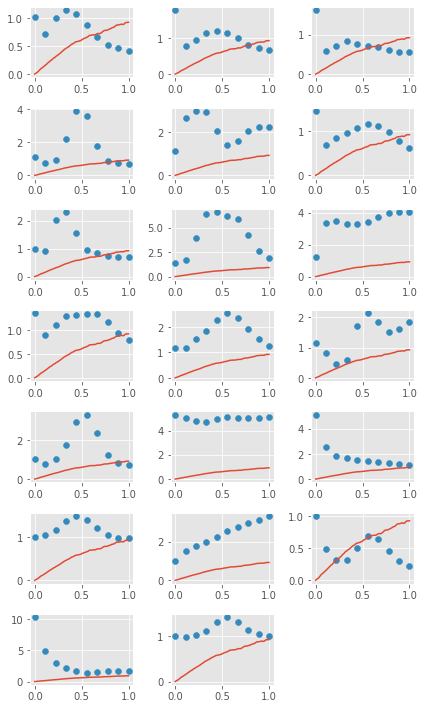

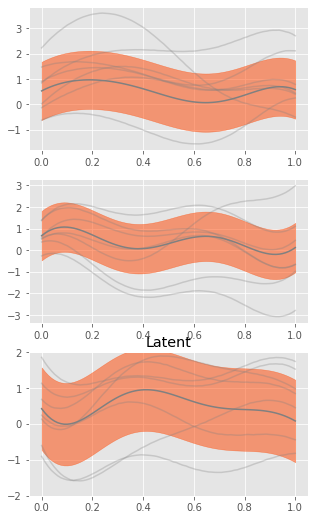

In [4]:
t_predict = torch.linspace(f64(0), f64(1), 80)
rtol = 1e-3
atol = rtol/10

model_kwargs = {
    'rtol': rtol, 'atol': atol,
    'num_samples': 1
}

plotter = Plotter(model, gene_names, t_inducing)
plotter.plot_outputs(t_predict, t_scatter=t_observed, y_scatter=dataset[0][1].transpose(0,1), model_kwargs=model_kwargs)
plotter.plot_latents(t_predict)

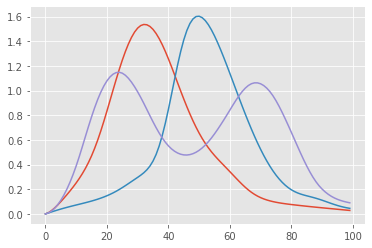

In [5]:
for i in range(num_tfs):
    plt.plot(dataset.f_observed[i])

In [12]:
import time
start = time.time()
tol = 1e-4
output = trainer.train(20, rtol=tol, atol=tol/10, report_interval=1, plot_interval=2)
end = time.time()
print(end - start)



Epoch 31/50 - Loss: 159.29 (78.01 81.29)
	 b: 1.06 d 5.63 s: 4.92 λ: 0.022
Epoch 32/50 - Loss: 152.35 (72.47 79.88)
	 b: 1.03 d 5.74 s: 5.08 λ: 0.022
Epoch 33/50 - Loss: 139.37 (60.78 78.59)
	 b: 0.95 d 5.88 s: 5.20 λ: 0.022
Error in callback <function flush_figures at 0x00000220770CBC18> (for post_execute):


KeyboardInterrupt: 

KeyboardInterrupt: 

with gpu:

### Outputs after training

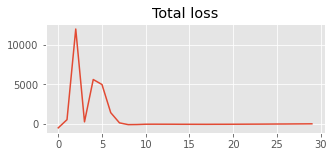

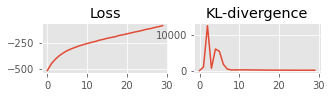

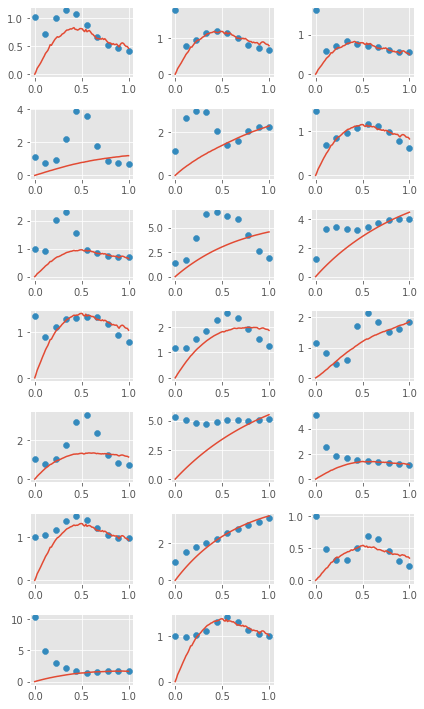

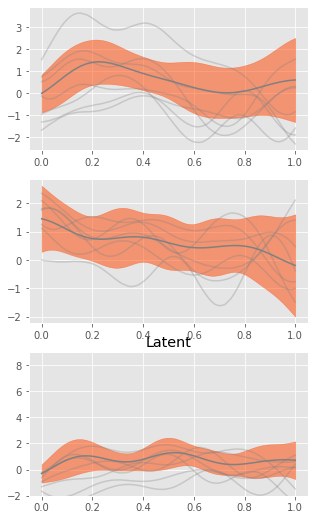

In [13]:
plotter = Plotter(model, gene_names, t_inducing)

tol = 1e-4
plotter.plot_losses(trainer, last_x=100)
plotter.plot_outputs(t_predict, t_scatter=t_observed, y_scatter=dataset[0][1].transpose(0,1), model_kwargs=model_kwargs)
plotter.plot_latents(t_predict, ylim=(-2, 9))


In [ ]:
save(model, 'multitf')

In [ ]:
model = load('nonlinear', MultiLFM, num_genes, num_tfs, t_inducing, t_observed, fixed_variance=None)
optimizer = torch.optim.Adam(model.parameters(), lr=0.2)
trainer = Trainer(model, optimizer, dataset)

In [ ]:
titles = ['basal', 'decay', 'sensitivity', 'lengthscale']
datas = [np.array(trainer.basalrates)[:,:,0],
         np.array(trainer.decayrates)[:,:,0],
         np.array(trainer.sensitivities)[:,:,0],
         np.array(trainer.lengthscales)]

plt.figure(figsize=(5, 6))
for i, (title, data) in enumerate(zip(titles, datas)):
    plt.subplot(411 + i)
    plt.title(title)
    # if data.ndim > 1:
    #     for j in range(data.shape[1]):

    plt.plot(data)